In [160]:
import networkx as nx
from node2vec import Node2Vec
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [176]:
# Load the list of authors in the training (for testing)
f_train = open("../Data/train.csv","r")
list_lines = f_train.readlines()
dict_h_index = {}

for line in list_lines[1:]:
    line = line.replace("\n","").split(",",1)
    dict_h_index[int(line[0])] = float(line[1])
    
num_nodes_subgraph = 100000
nodes_subgraph = random.sample(dict_h_index.keys(),num_nodes_subgraph)
h_index_subgraph = [dict_h_index[author_id] for author_id in nodes_subgraph]

(array([1.49951e+05, 1.70460e+04, 4.58700e+03, 1.98300e+03, 4.58000e+02,
        1.38000e+02, 5.50000e+01, 1.50000e+01, 5.00000e+00, 3.00000e+00]),
 array([  1. ,  19.6,  38.2,  56.8,  75.4,  94. , 112.6, 131.2, 149.8,
        168.4, 187. ]),
 <a list of 10 Patch objects>)

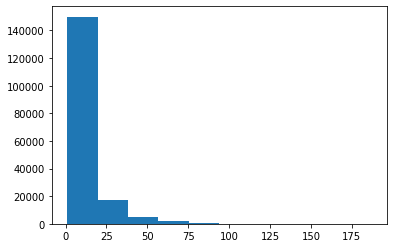

In [177]:
plt.hist(dict_h_index.values())

In [178]:
# Load the precomputed weighted graph
g_w = nx.read_edgelist('graph.weighted.edgelist', nodetype=int, data=True)

In [179]:
print('Some of the edges of the graph:\n')
count = 0
for (u,v,d) in g_w.edges(data=True):
    if(count > 10):
        break
    print("({0},{1},{2}) = ".format(u,v,d))
    count += 1

Some of the edges of the graph:

(2002218453,1999212242,{'coauthorship': 0}) = 
(2002218453,2032640503,{'coauthorship': 0}) = 
(2002218453,2475931411,{'coauthorship': 0}) = 
(2002218453,2477743428,{'coauthorship': 0}) = 
(2002218453,2504846374,{'coauthorship': 0}) = 
(2002218453,2597456557,{'coauthorship': 1}) = 
(2002218453,2598017501,{'coauthorship': 0}) = 
(2002218453,2134271654,{'coauthorship': 0}) = 
(2002218453,2138551865,{'coauthorship': 0}) = 
(2002218453,2145694960,{'coauthorship': 0}) = 
(2002218453,2196000661,{'coauthorship': 0}) = 


In [180]:
# Generate a subgraph for testing
sg_w = g_w.subgraph(nodes_subgraph)

In [181]:
n_nodes = sg_w.number_of_nodes()
n_edges = sg_w.number_of_edges()

print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

print('Some of the edges of the subgraph:\n')
count = 0
for (u,v,d) in sg_w.edges(data=True):
    if(count > 10):
        break
    print("({0},{1},{2}) = ".format(u,v,d))
    count += 1

Number of nodes: 100000
Number of edges: 579592
Some of the edges of the subgraph:

(2811232256,77003035,{'coauthorship': 0}) = 
(2811232256,321188025,{'coauthorship': 0}) = 
(2811232256,1587633846,{'coauthorship': 0}) = 
(2811232256,2017813316,{'coauthorship': 1}) = 
(2226913280,2043636978,{'coauthorship': 0}) = 
(2226913280,2091351895,{'coauthorship': 1}) = 
(2226913280,2200079295,{'coauthorship': 1}) = 
(1268514819,2079639830,{'coauthorship': 1}) = 
(1268514819,2312076978,{'coauthorship': 1}) = 
(1268514819,1823577077,{'coauthorship': 1}) = 
(1268514819,599369682,{'coauthorship': 1}) = 


(array([8.6003e+04, 9.8200e+03, 2.6410e+03, 1.1300e+03, 2.7700e+02,
        7.9000e+01, 3.5000e+01, 9.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([  1. ,  19.6,  38.2,  56.8,  75.4,  94. , 112.6, 131.2, 149.8,
        168.4, 187. ]),
 <a list of 10 Patch objects>)

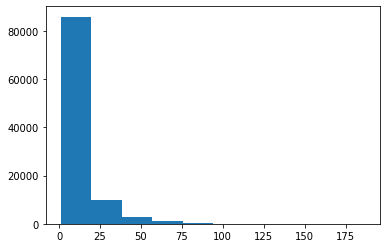

In [182]:
plt.hist(h_index_subgraph)

In [ ]:
# Precompute probabilities and generate walks
node2vec = Node2Vec(sg_w, dimensions=20, walk_length=16, num_walks=100, workers=1)

Generating walks (CPU: 1):   0%|                                                               | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1):  33%|█████████████████▏                                  | 33/100 [32:38<1:04:06, 57.41s/it]

In [ ]:
model = node2vec.fit(window=10, min_count=1)

In [ ]:
model.wv.most_similar(str(nodes_subgraph[0]))

In [ ]:
nodes_subgraph_str = [str(author_id) for author_id in nodes_subgraph]
embeddings = np.array([model.wv[author_id] for author_id in nodes_subgraph_str])

In [ ]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [ ]:
# Assign colors to groups
list_groups = [float(x) for x in range(25,-1,-5)]
group_colors = {
    '>=25.0': 'gainsboro',
    '>=20.0': 'lightblue',
    '>=15.0': 'b',
    '>=10.0': 'r',
    '>=5.0': 'teal',
    '>=0.0': 'deepskyblue',
}

colors = []

for author_id in nodes_subgraph:
    for value in list_groups:
        if(dict_h_index[author_id] >= value):
            colors.append(group_colors[">="+str(float(value))])
            break

In [ ]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches);

In [ ]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [ ]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches);